---
title: "US Treasuries"
author: "Louis Olive"
format:
  html:
    toc: true
    number-sections: true
---

In [1]:
import numpy as np

import pandas as pd

In [2]:
import os
from IPython.display import Image as Img

dir_data = '../data'

dir_assets = './assets'

def img_colab(img_path):
    '''
    Helper function returning an image to be displayed by Jupyter Notebook / IPython.display module.
    
    Parameters
    ----------
    path : path to image
        The image should be in a child folder "./assets".
    '''

    display(Img(os.path.join(dir_assets, img_path)))
    return None

In [55]:
#| code-fold: true
# # Within Google Colab (uncomment below)

# # mount my Google Drive on the VM
# from google.colab import drive
# drive.mount('/gdrive')

# # You should have already created a 'teaching_Python' folder 
# # within your Google Drive to persist code and data

# # the following code should then list the files in the data folder
# dir_python = '/gdrive/MyDrive/teaching_Python'

# dir_data = os.path.join(dir_python, 'data')
# os.listdir(dir_data)

Sometimes you have to use a http POST request, for example when dealing with forms. For example on the FED TreasuryDirect website, in order to get a daily list of US Treasury prices, you first have to specificy a value date:

<!---
do not work on Colab
portable alternative below
![Image](./assets/treasury_post_input.png)
-->

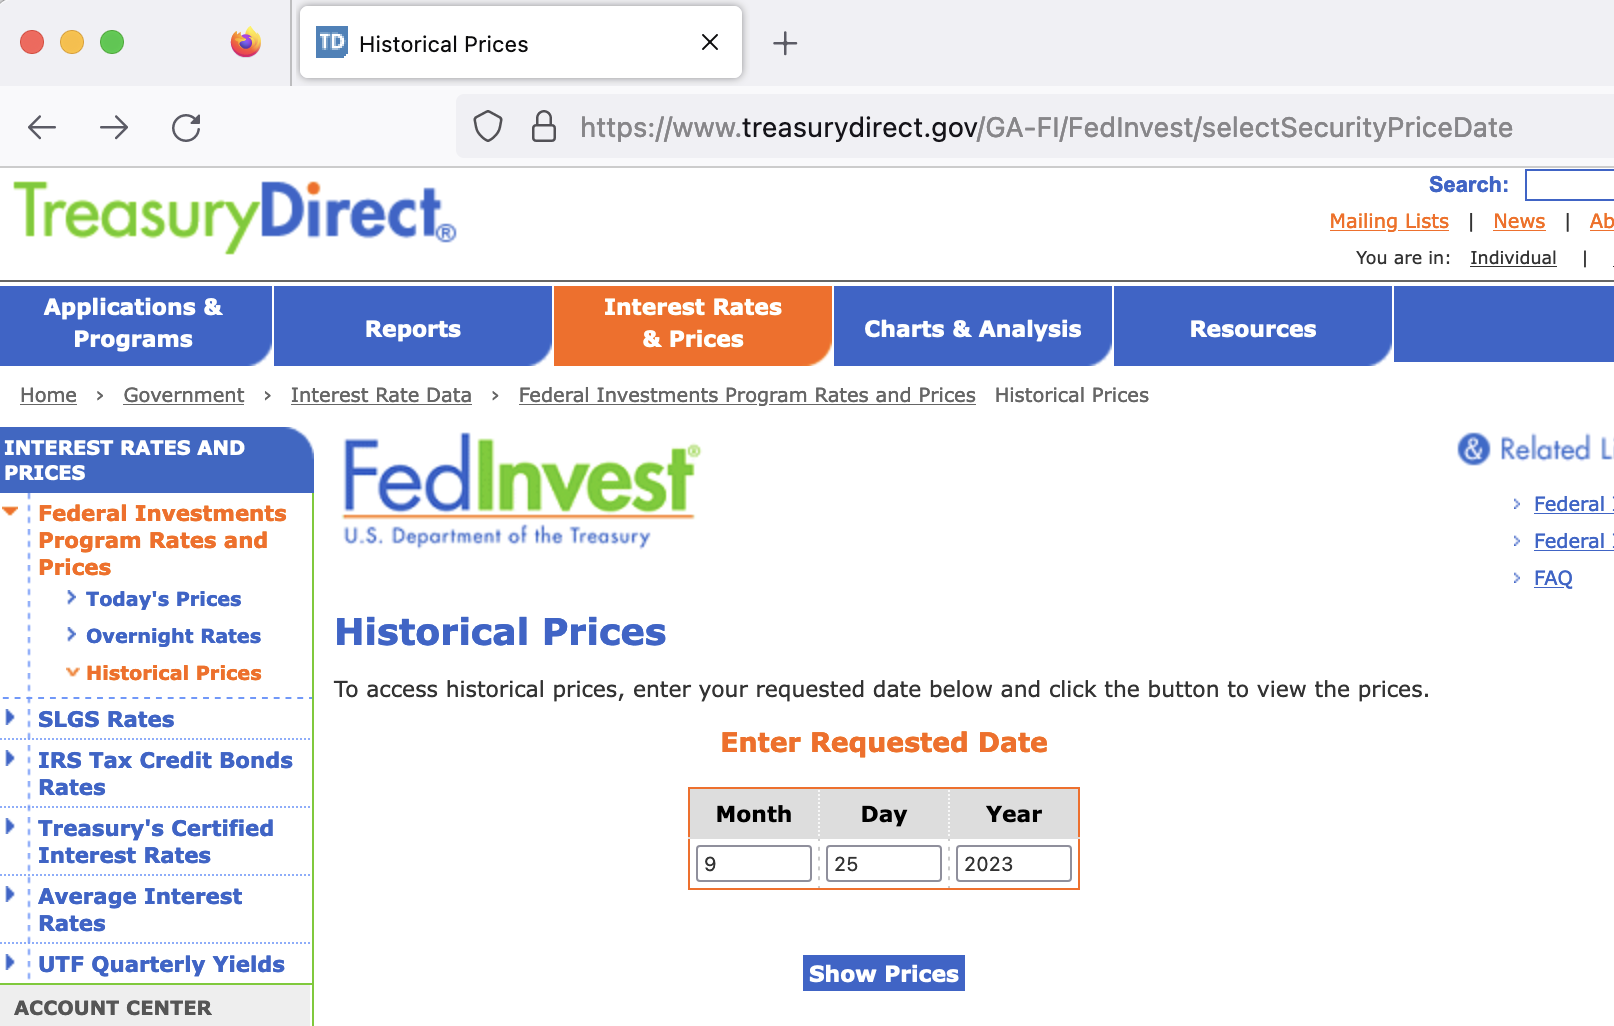

In [3]:
#| code-fold: true
img_colab('treasury_post_input.png')

Inspecting a little bit the web page, we see that a POST request is launched together with date parameters:

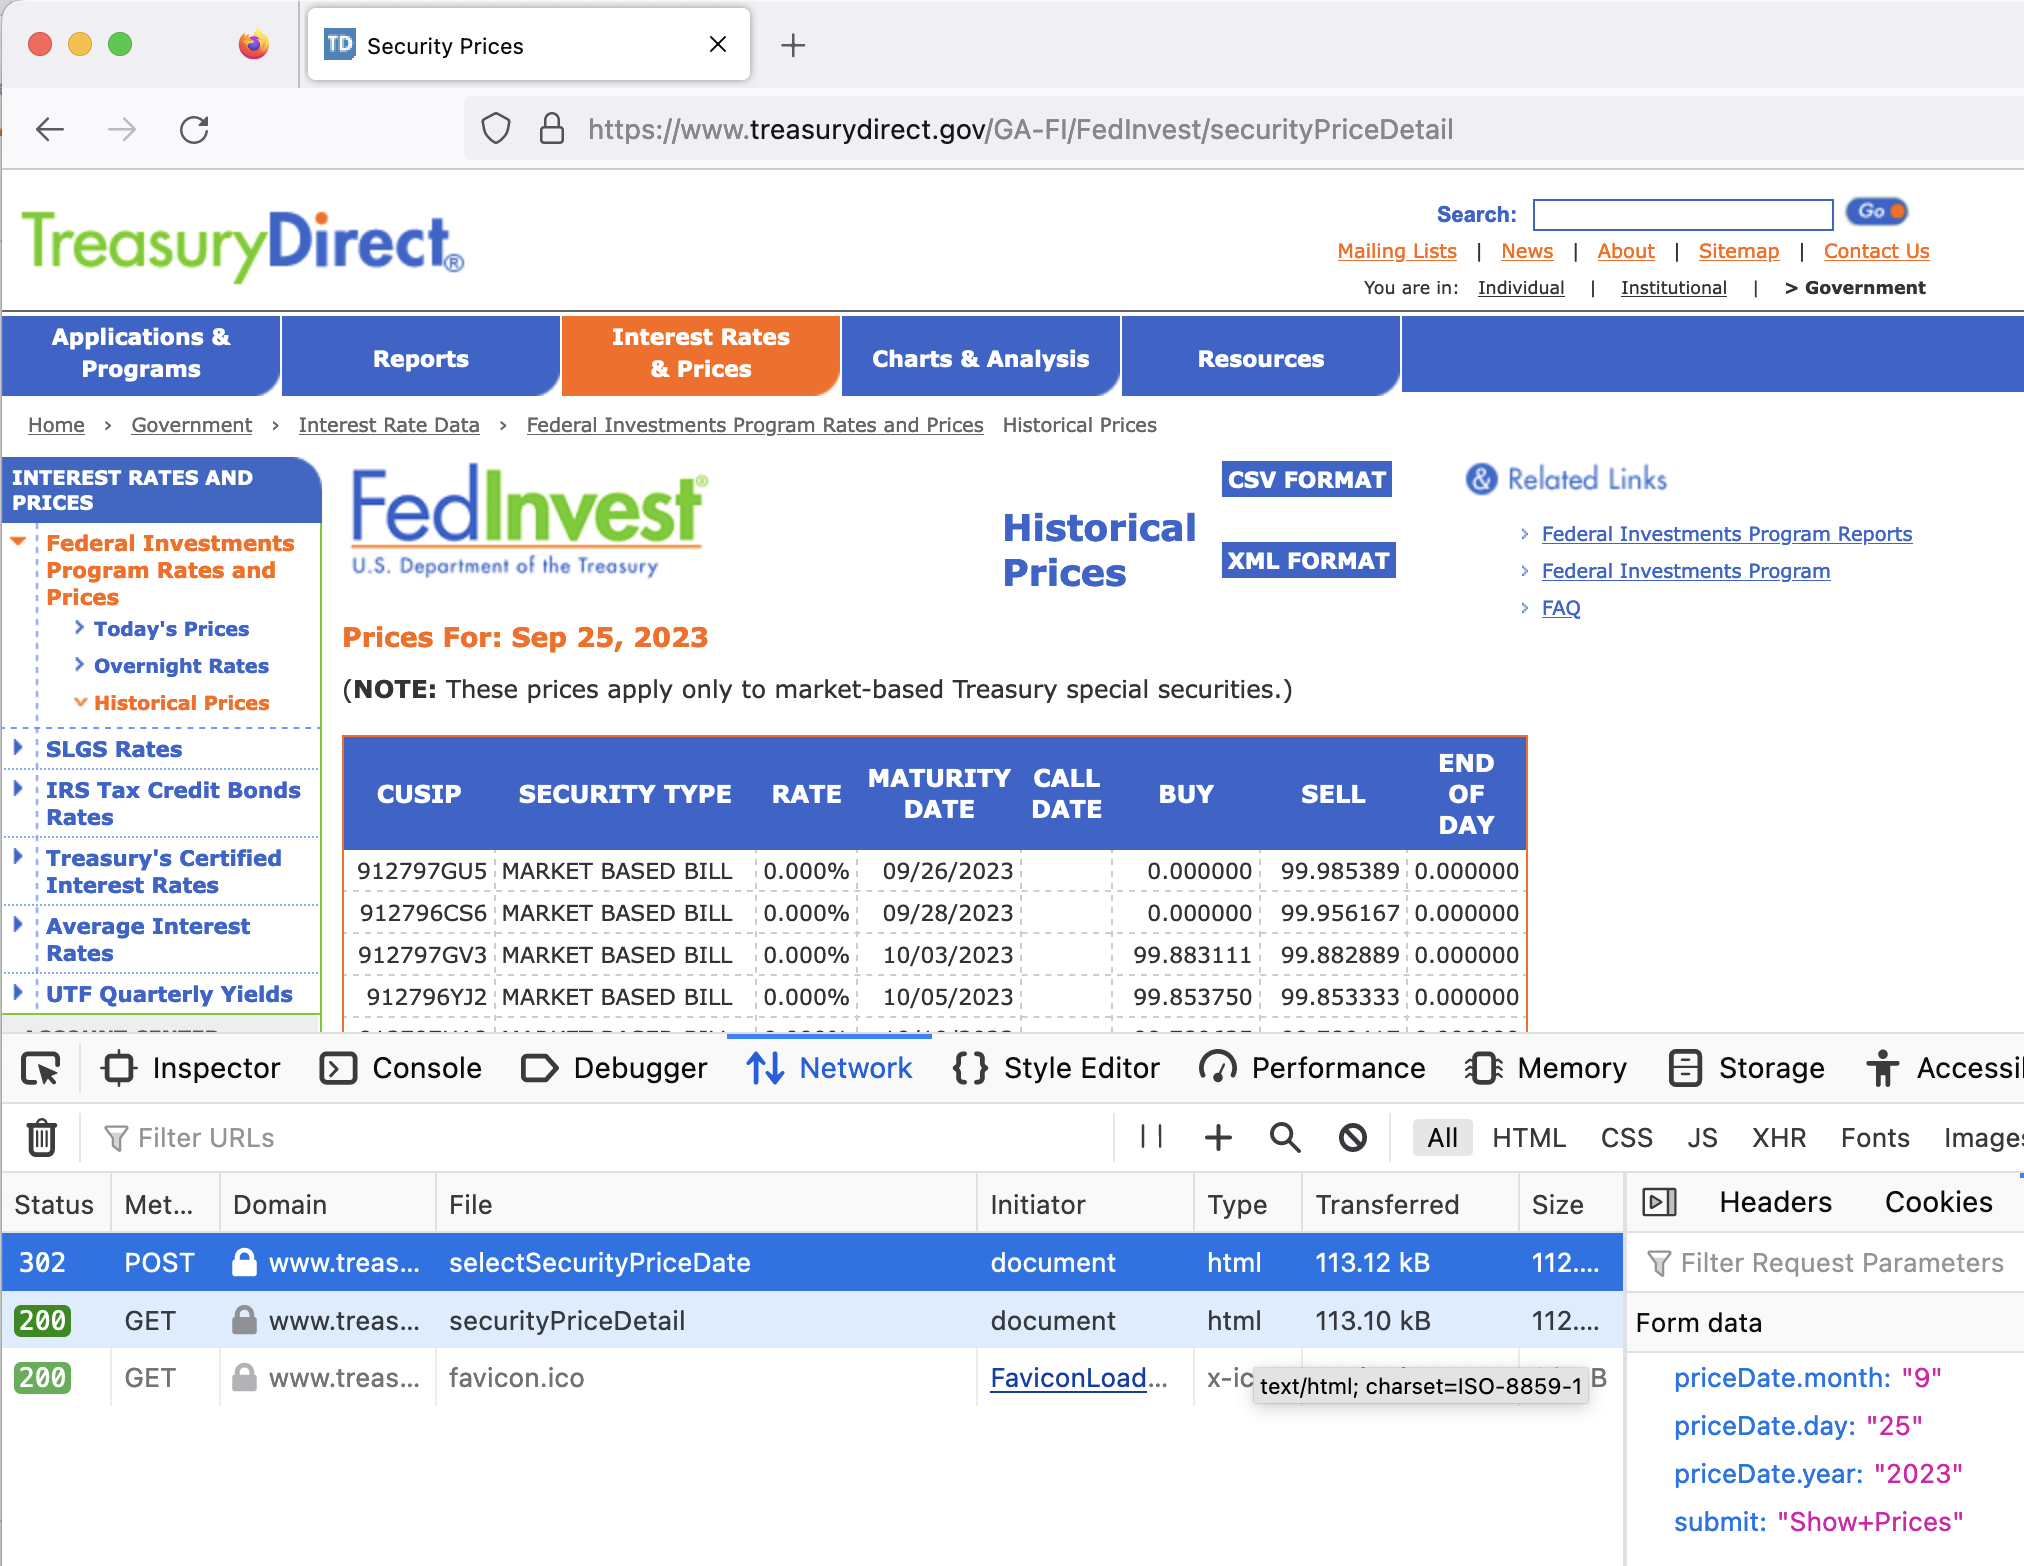

In [4]:
#| code-fold: true
img_colab('treasury_post_finish.png')

We can use `requests` package to submit a POST reauest with params:

In [5]:
treasury_post_url = 'https://www.treasurydirect.gov/GA-FI/FedInvest/selectSecurityPriceDate'

In [16]:
import requests
from bs4 import BeautifulSoup

from urllib import parse
from io import StringIO

month = 9
day = 25
year = 2023

user_agent = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'}

post_params = f'priceDate.month={month}&priceDate.day={day}&priceDate.year={year}&submit=Show+Prices'

r = requests.post(treasury_post_url, data=parse.parse_qs(post_params), headers=user_agent)
r

<Response [200]>

Reading the content of the response to pandas:

In [17]:
df_treasuries = pd.read_html(StringIO(str(BeautifulSoup(r.content))))[0]
df_treasuries.head(4)

,CUSIP,SECURITY TYPE,RATE,MATURITY DATE,CALL DATE,BUY,SELL,END OF DAY
0,912797GU5,MARKET BASED BILL,0.000%,09/26/2023,NaN,0.000000,99.985389,100.000000
1,912796CS6,MARKET BASED BILL,0.000%,09/28/2023,NaN,0.000000,99.956167,99.970778
2,912797GV3,MARKET BASED BILL,0.000%,10/03/2023,NaN,99.883111,99.882889,99.897528
3,912796YJ2,MARKET BASED BILL,0.000%,10/05/2023,NaN,99.853750,99.853333,99.868000


**Exercise** example of data analysis

The aim of the exercise is to scrape US Treasury data from `treasurydirect.gov` website given a range of dates then perform some analytics.

* Using Python [`datetime` package](https://docs.python.org/3/library/datetime.html) and given a start and end dates write a function returning a list of business days (you don't have to deal with business holidays in this function) within the range. The `.weekday()` method for datetime.date objects and `datetime.timedelta()` will be useful.

Basic usage of datetime:

```python
import datetime

start_date = datetime.date(2023, 9, 1)
end_date = datetime.date(2023, 9, 28) 

another_date = '27/09/2023'
another_date = datetime.datetime.strptime(another_date, '%d/%m/%Y').date()

print(another_date.year)
print(another_date.day)
print(another_date.month)

```

* Then for each business day, get US treasury prices from `treasurydirect.gov` using the post request that we have seen before. Store the results in a pandas DataFrame keeping the original columns CUSIP:END OF DAY but adding before a column VALUE DATE corresponding to the business day (you can use `.insert(loc=0,..)`). Then save this DataFrame to a .csv file in the `data` folder of your Classroom.

* The aim is now to be able to imply a yield from a US Treasury Note/Bond price and its characteristics (Coupon, Maturity). We decompose the problem in two steps:

    * first creating a function `price_bond` that given a pricing date, a maturity date, a coupon, a yield and assuming the coupon is paid bi-annualy returns the price of a bond. To simplify you can first start by assuming the pricing date is the issue date of the bond or a coupon date. Then handle any pricing dates.

    * second given this function `price_bond` and a bond price `P`, "imply" the yield to maturity being the yield to input to `price_bond` to retrieve the bond price. For that you will have to use a solver or an optimizer. Basically you want to find the yield solving `price_bond(yield)`- `P` = 0. For that you can implement from scratch for example a bisection method (see Wikipedia article [here](https://en.wikipedia.org/wiki/Bisection_method) and also [here](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter19.00-Root-Finding.html) for root finding methods with Python) or use the `scipy.optimize.bisect` or `scipy.optimize.newton`. Once finished put your program inside a `bond_ytm` function.

* Apply the `bond_ytm` to your pandas DataFrame of US treasury prices, to get a bid/ask yield to maturity for each day/CUSIP where SECURITY TYPE is either `MARKET BASED NOTE` or `MARKET BASED BOND`.

* Plot for a given business day the yields of US Treasuries with respect to their maturity to get a first sense of the data

* The ECB and many other central banks use the Nelson Siegel parametrization [see here](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html) to estimate euro area government bond yield curves from government bonds market prices. The original motivation for this model was to create a parsimonious model of the interest rate curve that could capture the range of shapes generally seen in yield curves: monotonic form and with humps in various areas of the curve. The Nelson-Siegel yield function (1987) take the form:


$$
y(m) = \beta_0 +
\beta_1  \frac{\left( 1 - \exp (-
m / \tau) \right)}{m / \tau}  + \beta_2  \left( \frac{\left( 1 - \exp (-
m / \tau) \right)}{m / \tau} - \exp \left( -
m / \tau \right)  \right)
$$

Svensson (1994) adds the additional term:


$$
+ \beta_3  \left( \frac{\left( 1 - \exp (-
m / \tau_2) \right)}{m / \tau_2} - \exp \left( -
m / \tau_2 \right)  \right)
$$

* Using Python [`datetime` package](https://docs.python.org/3/library/datetime.html) and given a start and end dates write a function returning a list of business days (you don't have to deal with business holidays in this function) within the range. The `.weekday()` method for datetime.date objects and `datetime.timedelta()` will be useful.

In [8]:
import datetime

In [9]:
start_date = datetime.date(2023, 9, 14)
end_date = datetime.date(2023, 9, 29)
print(f'Date range: [{start_date}, {end_date}]')

Date range: [2023-09-14, 2023-09-29]


In [10]:
# YOUR CODE HERE
def generate_bizdays(start_date, end_date):
    bizdays = []
    curr_date = start_date

    ####

    return bizdays

bizdays = generate_bizdays(start_date, end_date)
bizdays

[]

 * Then for each business day, get US treasury prices from `treasurydirect.gov` using the post request that we have seen before. Store the results in a pandas DataFrame keeping the original columns CUSIP:END OF DAY but adding before a column VALUE DATE corresponding to the business day (you can use `.insert(loc=0,..)`). Then save this DataFrame to a .csv file in the `data` folder of your Classroom.

In [11]:
# YOUR CODE HERE
def get_treasury_prices(bizdays):

    dict_df_treasuries = {}

    for date in bizdays:
        #####
        #####
    return dict_df_treasuries

IndentationError: expected an indented block after 'for' statement on line 6 (158366838.py, line 9)

In [ ]:
dict_df_treasuries = get_treasury_prices(bizdays)

2023-09-14
2023-09-15
2023-09-18
2023-09-19
2023-09-20
2023-09-21
2023-09-22
2023-09-25
2023-09-26
2023-09-27
2023-09-28
2023-09-29


In [ ]:
df_treasuries_prices = pd.concat([v for _,v in dict_df_treasuries.items() if isinstance(v, pd.DataFrame)],
                                 ignore_index=True)
print(df_treasuries_prices.dtypes)
df_treasuries_prices.head(4)

VALUE DATE       datetime64[ns]
CUSIP                    object
SECURITY TYPE            object
RATE                    float64
MATURITY DATE    datetime64[ns]
CALL DATE               float64
BUY                     float64
SELL                    float64
END OF DAY              float64
dtype: object


,VALUE DATE,CUSIP,SECURITY TYPE,RATE,MATURITY DATE,CALL DATE,BUY,SELL,END OF DAY
0,2023-09-14,912797GT8,MARKET BASED BILL,0.0,2023-09-19,NaN,0.000000,99.926944,99.941333
1,2023-09-14,912796CR8,MARKET BASED BILL,0.0,2023-09-21,NaN,99.898111,99.897917,99.912500
2,2023-09-14,912797GU5,MARKET BASED BILL,0.0,2023-09-26,NaN,99.825167,99.824667,99.838972
3,2023-09-14,912796CS6,MARKET BASED BILL,0.0,2023-09-28,NaN,99.796417,99.795444,99.809333


In [ ]:
df_treasuries_prices.tail(4)

,VALUE DATE,CUSIP,SECURITY TYPE,RATE,MATURITY DATE,CALL DATE,BUY,SELL,END OF DAY
5305,2023-09-29,91282CFS5,MARKET BASED FRN,0.05620,2024-10-31,NaN,100.098973,100.077777,100.083075
5306,2023-09-29,91282CGF2,MARKET BASED FRN,0.05681,2025-01-31,NaN,100.154413,100.128462,100.131705
5307,2023-09-29,91282CGY1,MARKET BASED FRN,0.05649,2025-04-30,NaN,100.056931,100.039800,100.051218
5308,2023-09-29,91282CHS3,MARKET BASED FRN,0.05605,2025-07-31,NaN,99.921257,99.912499,99.916878


Saving to csv

In [ ]:
df_treasuries_prices.to_csv(os.path.join(dir_data, 'df_treasuries_prices.csv'), index=False)

* The aim is now to be able to imply a yield from a US Treasury Note/Bond price and its characteristics (Coupon, Maturity). We decompose the problem in two steps:

    * first creating a function `price_bond` that given a pricing date, a maturity date, a coupon, a yield and assuming the coupon is paid bi-annualy returns the price of a bond. To simplify you can first start by assuming the pricing date is the issue date of the bond or a coupon date. Then handle any pricing dates.

To set these ideas on a simple example, let's choose a specific Treasury Note, with CUSIP number 91282CDN8, maturing December 15, 2024, paying a 1% coupon semi-annually:

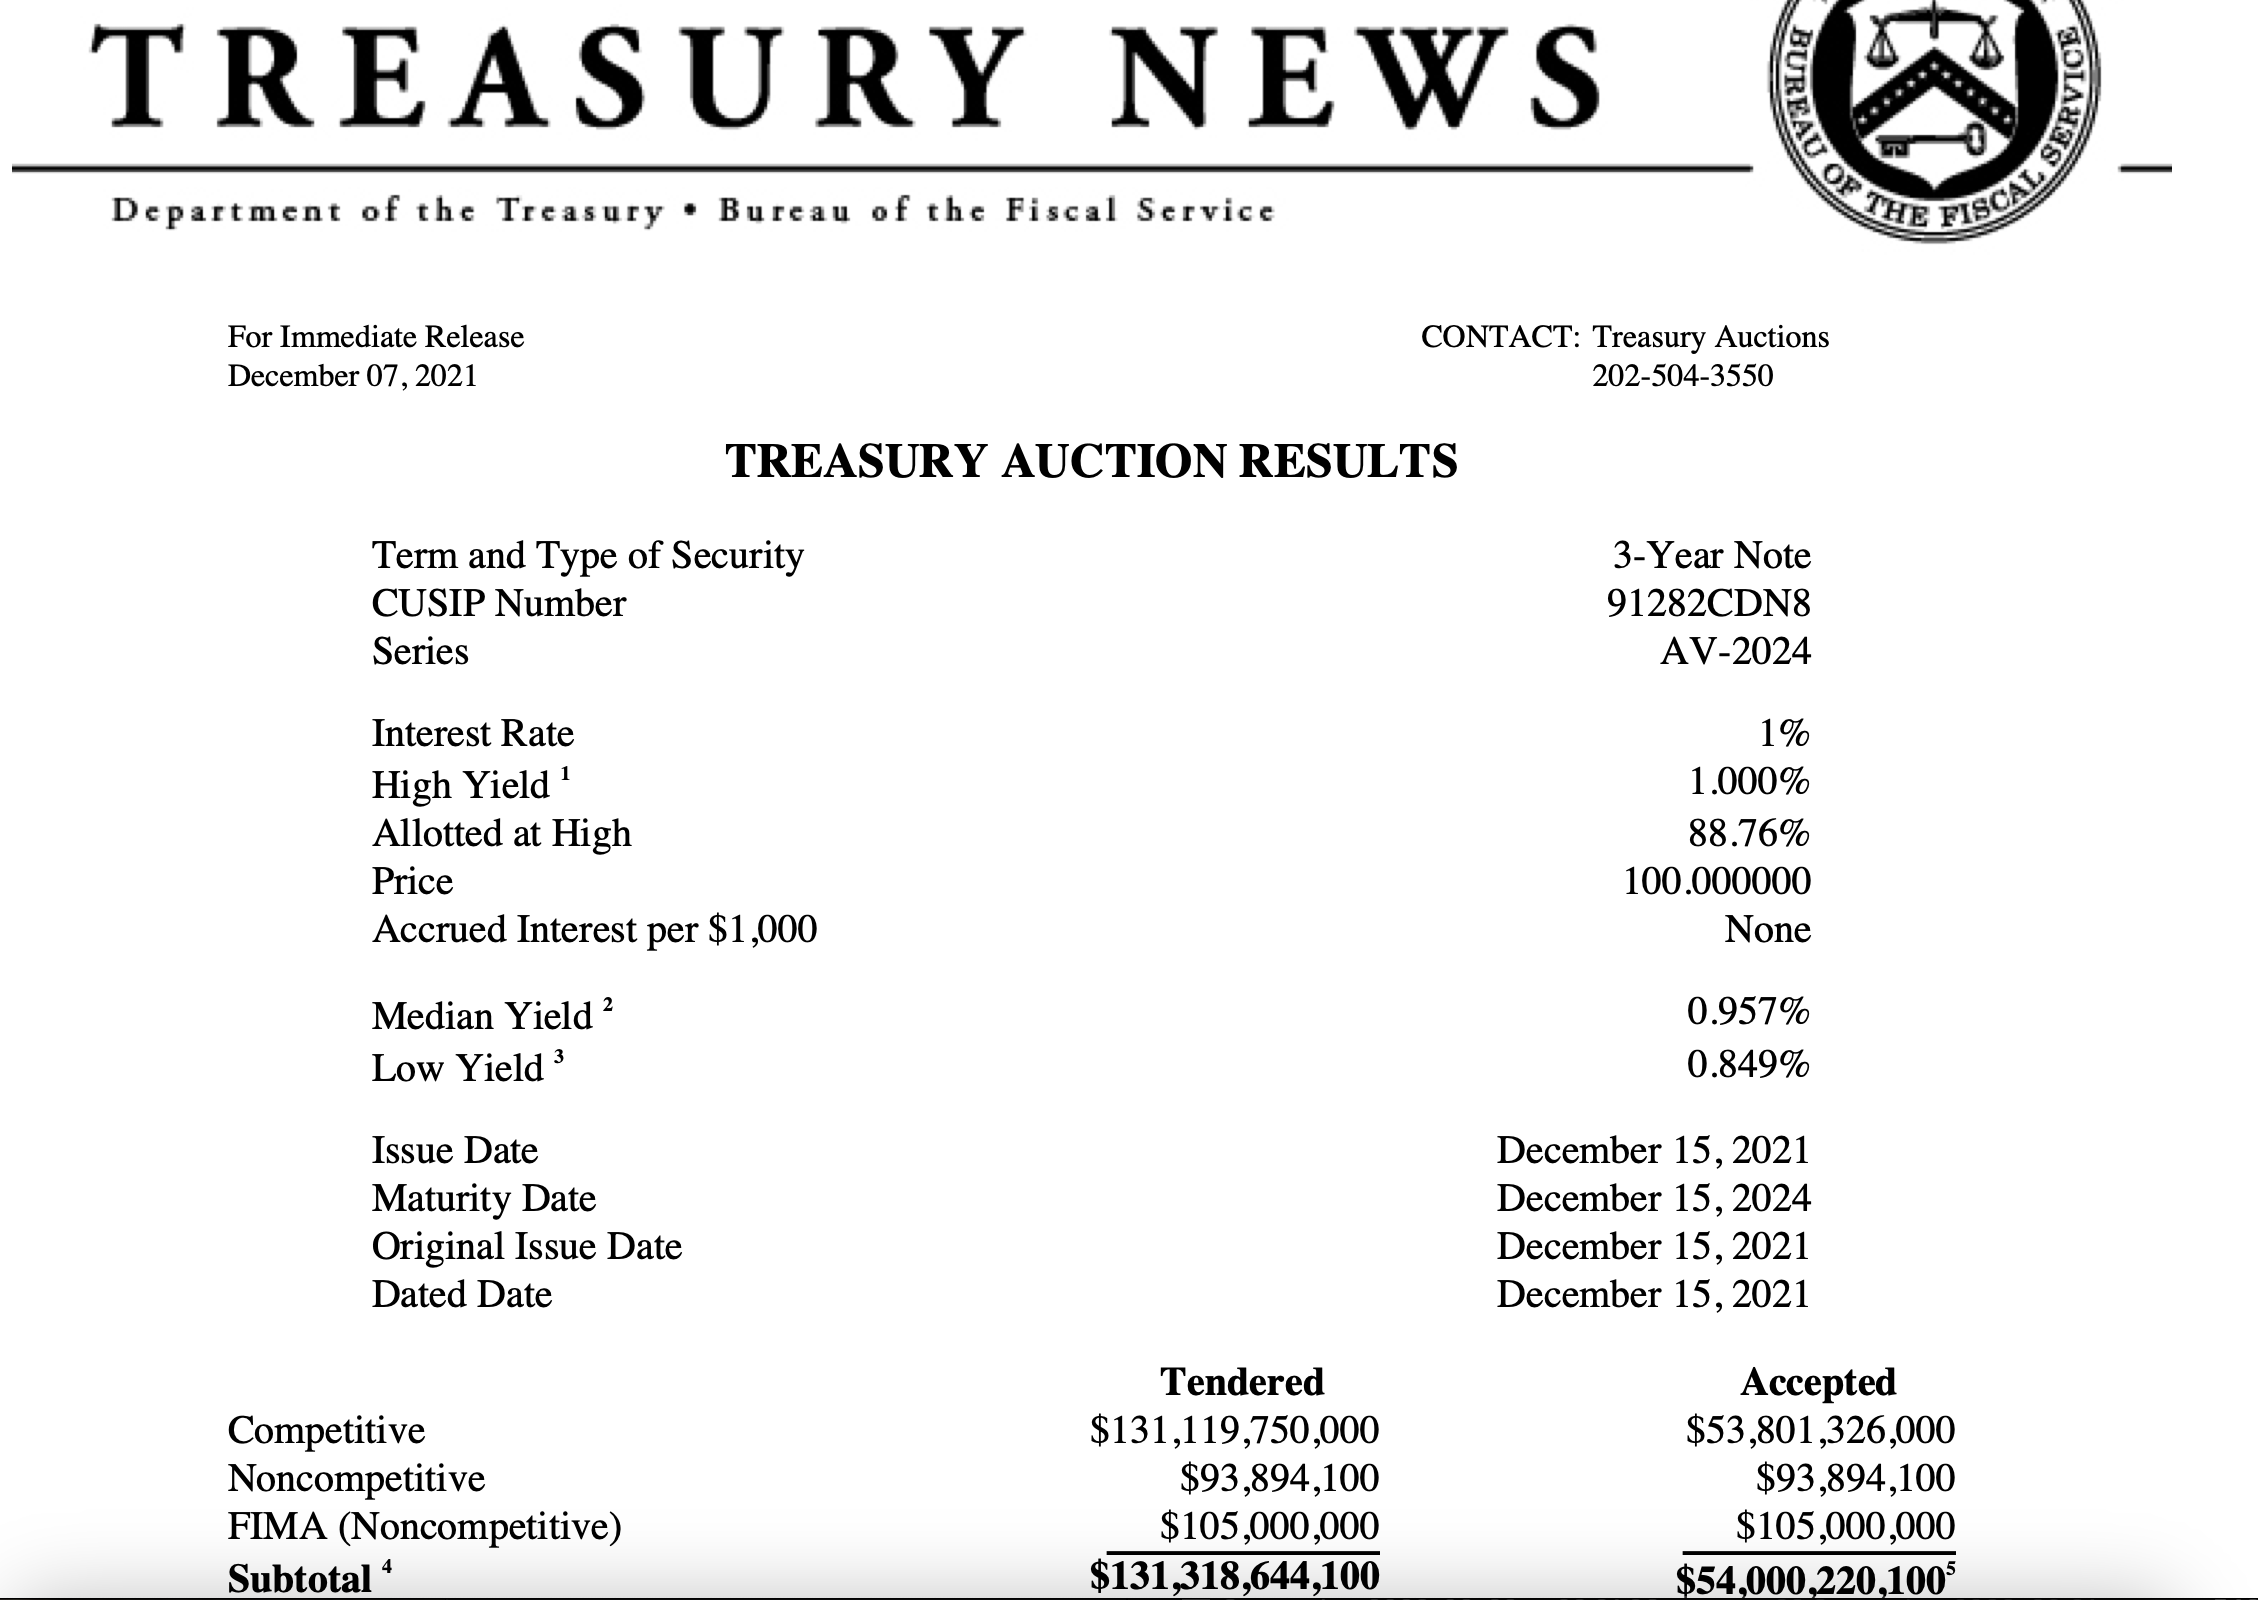

In [ ]:
#| code-fold: true
img_colab('91282CDN8_issue.png')

We define here the bond main characteristics:

In [12]:
clean_price = 94.984375
par_value = 100
pricing_date = '29/09/2023'
last_coupon = '15/06/2023'
next_coupon = '15/12/2023'
maturity_date = '15/12/2024'
issue_date = '15/12/2021'

coupon = 1.0
freq = 2

We remind here the bond yield problem as stated in [this ISMA publication](https://www.icmagroup.org/assets/documents/Media/Bondmarketsbook/Bond%20markets_structures%20and%20yield%20calculations.pdf):

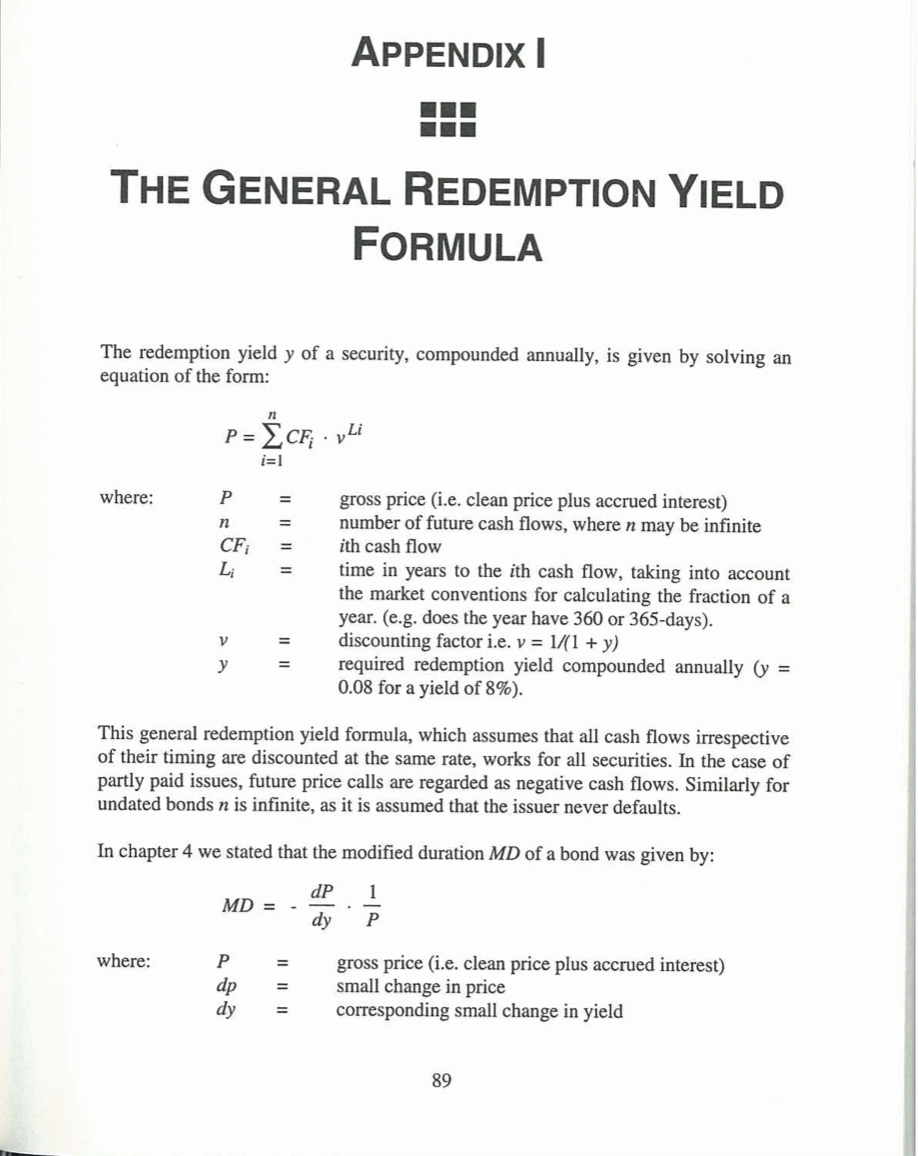

In [13]:
#| code-fold: true
img_colab('yield_formula_I.png')

We first start with a naive implementation, without caring too much about daycount conventions, ajustments etc:

In [ ]:
# YOUR CODE HERE
def bond_price_naive(yld, pricing_date, maturity_date, coupon, redemption, frequency, verbose=False):


    return clean_price

In [ ]:
bond_price_naive(yld = 0.05391482199427463,
pricing_date = datetime.datetime.strptime(pricing_date, '%d/%m/%Y'),
maturity_date = datetime.datetime.strptime(maturity_date, '%d/%m/%Y'),
coupon = coupon,
redemption = 100,
frequency = freq,
verbose=True)

Clean price: 94.98437500001599
Dirty price: 95.270676369879
Accrued interest: 0.2863013698630137
Cashflow schedule: [0.2136986301369863, 0.7136986301369863, 1.2136986301369863]


94.98437500001599

We plot the Clean Price function with respect to yield, we briefly introduce here some `NumPy` objects; `np.linspace()` allows to return evenly spaced numbers over a specified interval, which can be useful in the context of ploting a function.



In [ ]:
# YOUR CODE HERE

x = np.linspace(-0.01, 0.1, 150)

# y = ???

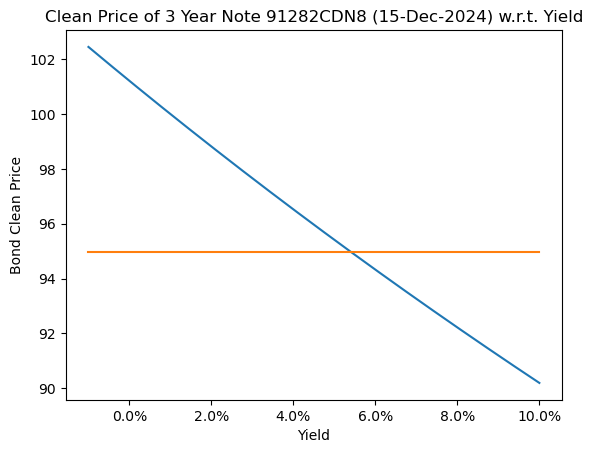

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, clean_price * np.ones_like(x))
ax.set(xlabel='Yield', ylabel='Bond Clean Price',
       title='Clean Price of 3 Year Note 91282CDN8 (15-Dec-2024) w.r.t. Yield')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.show()

We use `scipy.optimize.newton()` to equalize market price to bond price function at the yield to maturity:

In [ ]:
# YOUR CODE HERE
def bond_ytm_naive(clean_price, pricing_date, maturity_date, coupon, redemption, frequency, ytm_0):
    
     return ytm

In [ ]:
bond_ytm_naive(clean_price = clean_price,
pricing_date = datetime.datetime.strptime(pricing_date, '%d/%m/%Y'),
maturity_date = datetime.datetime.strptime(maturity_date, '%d/%m/%Y'),
coupon = coupon,
redemption = 100,
frequency = freq,
ytm_0 = 0.03)

Clean price: 94.98437500001599
Dirty price: 95.270676369879
Accrued interest: 0.2863013698630137
Cashflow schedule: [0.2136986301369863, 0.7136986301369863, 1.2136986301369863]


0.05391482199427463

As an alternative to `scipy.optimize.bisect` or `scipy.optimize.newton`, we propose here to implement ourselves three different solvers as suggested in the exercise:

First using the bisection method as described in the Wikipedia article [here](https://en.wikipedia.org/wiki/Bisection_method) (see also [here](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter19.00-Root-Finding.html)):

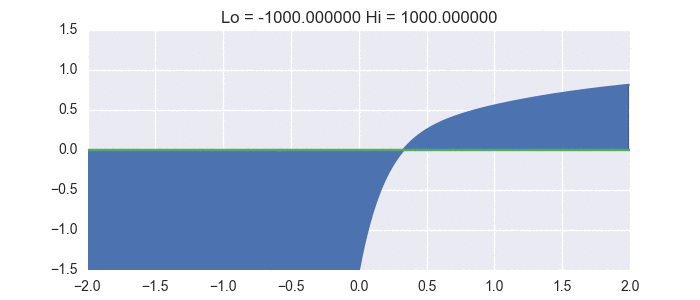

In [ ]:
#| code-fold: true
# source https://github.com/better/irr
img_colab('bisect.gif')

In [14]:
# YOUR CODE HERE
def solve_root_bisection(func, a, b, tol = 1e-8, n_iter = 200, verbose = False):
    return

Then using the [Secant method](https://en.wikipedia.org/wiki/Secant_method) (which we already used using scipy.optimize.newton as we didn't pass a derivative function to the optimizer):

In [ ]:
# YOUR CODE HERE
def solve_root_secant(func, x0, x1, tol = 1e-8, n_iter = 200, verbose = False):
    return

And to finish using the [Newton method](https://en.wikipedia.org/wiki/Newton%27s_method): 

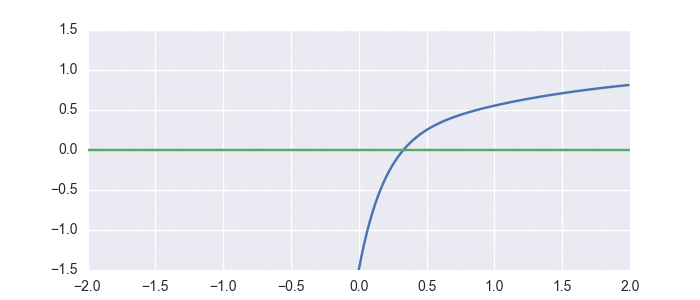

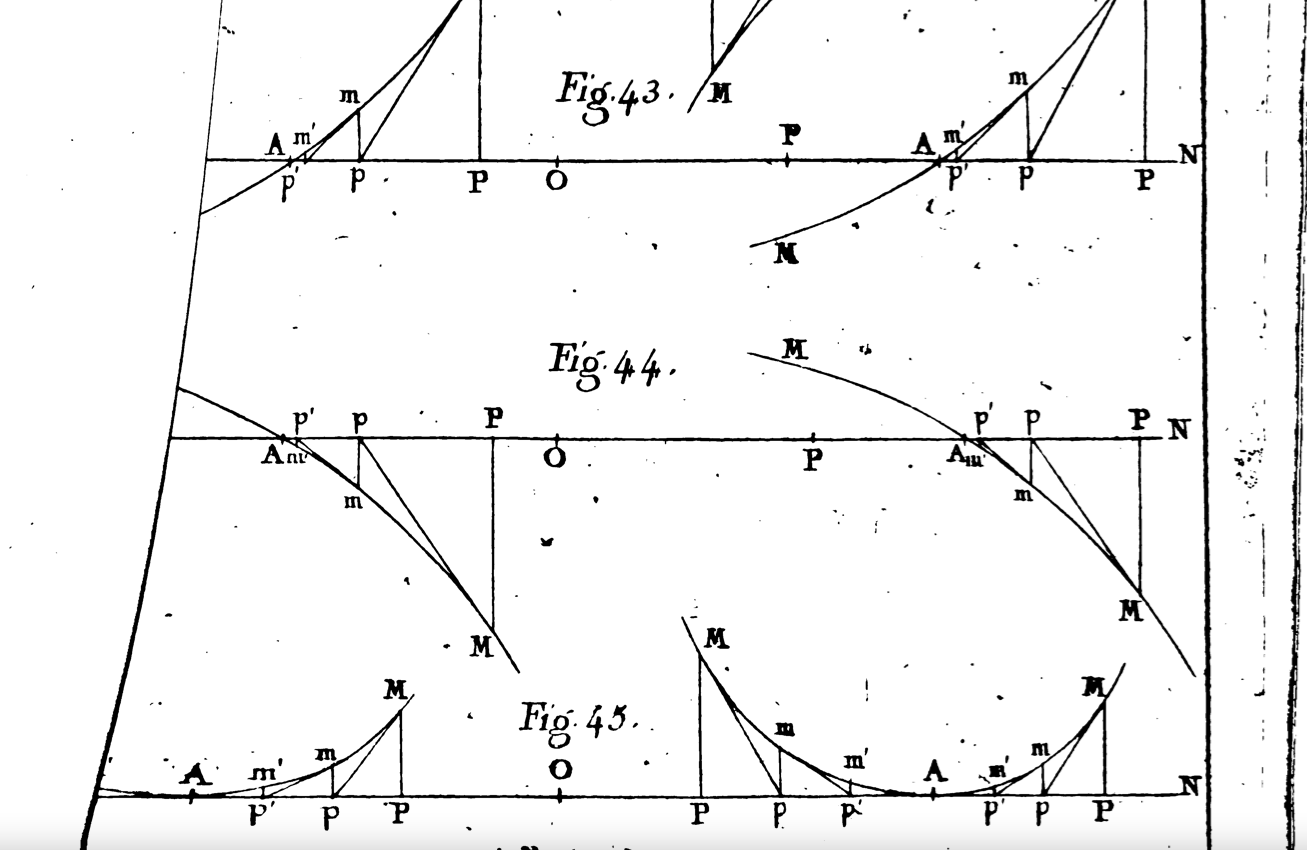

In [ ]:
#| code-fold: true
img_colab('newton.gif')
img_colab('newton_method.png')

In [ ]:
# YOUR CODE HERE
def solve_root_newton(func, deriv, x0, tol = 1e-8, n_iter = 200, verbose = False):
    return

Checking our functions to compute sqrt(2) as a solution to x ** 2 - 2 = 0 on [1, 2]:

In [ ]:
# defining equation to solve
f = lambda x: x ** 2 - 2

print('------------------ bisection method ------------------')
sqrt_2 = solve_root_bisection(f, 1, 2, 1e-8, 200, True)
print(sqrt_2)


------------------ bisection method ------------------
m: 1.5
f(m): 0.25
1 neg
a: 1 - root - b:1.5
m: 1.25
f(m): -0.4375
2 pos
a: 1.25 - root - b:1.5
m: 1.375
f(m): -0.109375
3 pos
a: 1.375 - root - b:1.5
m: 1.4375
f(m): 0.06640625
4 neg
a: 1.375 - root - b:1.4375
m: 1.40625
f(m): -0.0224609375
5 pos
a: 1.40625 - root - b:1.4375
m: 1.421875
f(m): 0.021728515625
6 neg
a: 1.40625 - root - b:1.421875
m: 1.4140625
f(m): -0.00042724609375
7 pos
a: 1.4140625 - root - b:1.421875
m: 1.41796875
f(m): 0.0106353759765625
8 neg
a: 1.4140625 - root - b:1.41796875
m: 1.416015625
f(m): 0.005100250244140625
9 neg
a: 1.4140625 - root - b:1.416015625
m: 1.4150390625
f(m): 0.0023355484008789062
10 neg
a: 1.4140625 - root - b:1.4150390625
m: 1.41455078125
f(m): 0.0009539127349853516
11 neg
a: 1.4140625 - root - b:1.41455078125
m: 1.414306640625
f(m): 0.0002632737159729004
12 neg
a: 1.4140625 - root - b:1.414306640625
m: 1.4141845703125
f(m): -8.200109004974365e-05
13 pos
a: 1.4141845703125 - root - b:1.41

In [ ]:
print('------------------ secant method ------------------')
print(solve_root_secant(f, 1, 2, 1e-8, 200, True))


------------------ secant method ------------------
Step 2: xn-2: 1, xn-1: 2, xn: 1.3333333333333335, f(xn): -0.22222222222222188
Step 3: xn-2: 2, xn-1: 1.3333333333333335, xn: 1.4000000000000001, f(xn): -0.03999999999999959
Step 4: xn-2: 1.3333333333333335, xn-1: 1.4000000000000001, xn: 1.4146341463414633, f(xn): 0.0011897679952408424
Step 5: xn-2: 1.4000000000000001, xn-1: 1.4146341463414633, xn: 1.41421143847487, f(xn): -6.007286838860537e-06
Step 6: xn-2: 1.4146341463414633, xn-1: 1.41421143847487, xn: 1.4142135620573204, f(xn): -8.931455575122982e-10
root found within tolerance 1e-08 at iteration 6
1.4142135620573204


In [ ]:
print('------------------ newton method ------------------')
# defining derivative
df = lambda x: 2 * x 
print(solve_root_newton(f, df, 1, 1e-8, 200, True))

import math
abs(sqrt_2 - math.sqrt(2)) < 1e-8

------------------ newton method ------------------
Step 1: xn: 1, xn+1: 1.5, f(xn+1): 0.25
Step 2: xn: 1.5, xn+1: 1.4166666666666667, f(xn+1): 0.006944444444444642
Step 3: xn: 1.4166666666666667, xn+1: 1.4142156862745099, f(xn+1): 6.007304882871267e-06
Step 4: xn: 1.4142156862745099, xn+1: 1.4142135623746899, f(xn+1): 4.510614104447086e-12
root found within tolerance 1e-08 at iteration 4
1.4142135623746899


True

* Apply the `yield_from_price` to your pandas DataFrame of US treasury prices, to get a bid/ask yield to maturity for each day/CUSIP where SECURITY TYPE is either `MARKET BASED NOTE` or `MARKET BASED BOND`.

In [15]:
#| code-fold: true
mask = df_treasuries_prices['SECURITY TYPE'].isin(['MARKET BASED NOTE', 'MARKET BASED BOND'])

df_treasuries_bonds = (df_treasuries_prices[mask].
rename(
    columns={
        'VALUE DATE': 'VALUE_DATE', 
        'MATURITY DATE': 'MATURITY_DATE'
    }
))
df_treasuries_bonds['RATE'] *= 100
df_treasuries_bonds.head(4)

NameError: name 'df_treasuries_prices' is not defined